<a href="https://colab.research.google.com/github/reykel/machine_learning_keras_tf_owned/blob/main/00-colorectal_histology_vit_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=ff7d04702d4f0aafdea421b69533cb4caad8ceda8b0eff0fc53e7f7e130ae9f6
  Stored in directory: /root/.cache/pip/wheels/2d/f0/a8/1094fca7a7e5d0d12ff56e0c64675d72aa5cc81a5fc200e849
Successfully built validators


In [2]:
!nvidia-smi

Sat Mar 11 17:25:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras import layers

In [5]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [6]:
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [7]:
from vit_keras import vit, utils
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.optimizers import Adam

In [8]:
(train_ds, validation_ds, test_ds), info = tfds.load(
    "colorectal_histology",
    split=["train[:90%]", "train[90%:95%]", "train[95%:]"],
    with_info=True,
    as_supervised=True,
)

num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteFUAE3X/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [9]:
size = (256, 256)
batch_size = 16 #64

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=1)
validation_ds = validation_ds.batch(batch_size).prefetch(buffer_size=1)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=1)

In [11]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomFlip("vertical"),     
     layers.RandomRotation(0.1),]
)

In [12]:
image_size = 256

base_model = vit.vit_b16(
    image_size=image_size,
    activation='relu',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
)

347502902/347502902 [==============================] - 99s 0us/step


/usr/local/lib/python3.9/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


In [13]:
for layer in base_model.layers:
    layer.trainable=False

In [14]:
inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)

scale_layer = keras.layers.Rescaling(scale=1.0/255)
x = scale_layer(x)

x = base_model(x, training=False)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

In [15]:
model = keras.Model(inputs, outputs)


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 8)                 6152      
                                                                 
Total params: 85,850,888
Trainable params: 6,152
Non-trainabl

In [22]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True,
    verbose=1
    )

In [23]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [20]:
epochs = 100
model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback])

Epoch 1/100
282/282 [==============================] - 99s 350ms/step - loss: 0.2628 - accuracy: 0.9084 - val_loss: 0.2659 - val_accuracy: 0.8920
Epoch 2/100
282/282 [==============================] - 98s 346ms/step - loss: 0.2466 - accuracy: 0.9118 - val_loss: 0.2537 - val_accuracy: 0.9000
Epoch 3/100
282/282 [==============================] - 99s 349ms/step - loss: 0.2356 - accuracy: 0.9184 - val_loss: 0.2381 - val_accuracy: 0.9160
Epoch 4/100
282/282 [==============================] - 98s 346ms/step - loss: 0.2242 - accuracy: 0.9153 - val_loss: 0.2538 - val_accuracy: 0.9080
Epoch 4: early stopping


In [21]:
score = model.evaluate(train_ds, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

282/282 [==============================] - 85s 302ms/step - loss: 0.1673 - accuracy: 0.9404
Test loss: 0.16732382774353027
Test accuracy: 0.9404444694519043


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
%cd  /content/drive/MyDrive/Unizar/Nets/ViT/Weights/V1

model.save_weights('weights.data')

/content/drive/MyDrive/Unizar/Nets/ViT/Weights/V1


In [26]:
for layer in base_model.layers:
    layer.trainable=True

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 8)                 6152      
                                                                 
Total params: 85,850,888
Trainable params: 85,850,888
Non-tra

In [27]:
model.compile(
    optimizer=Adam(1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [28]:
epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5


282/282 [==============================] - 277s 909ms/step - loss: 0.2030 - accuracy: 0.9262 - val_loss: 0.2152 - val_accuracy: 0.9240
Epoch 2/5
282/282 [==============================] - 252s 893ms/step - loss: 0.1930 - accuracy: 0.9298 - val_loss: 0.2112 - val_accuracy: 0.9160
Epoch 3/5
282/282 [==============================] - 252s 895ms/step - loss: 0.1731 - accuracy: 0.9398 - val_loss: 0.2019 - val_accuracy: 0.9160
Epoch 4/5
282/282 [==============================] - 251s 889ms/step - loss: 0.1566 - accuracy: 0.9464 - val_loss: 0.1971 - val_accuracy: 0.9120
Epoch 5/5
282/282 [==============================] - 252s 894ms/step - loss: 0.1529 - accuracy: 0.9458 - val_loss: 0.1897 - val_accuracy: 0.9200


In [29]:
score = model.evaluate(train_ds, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

282/282 [==============================] - 86s 303ms/step - loss: 0.1077 - accuracy: 0.9609
Test loss: 0.10774442553520203
Test accuracy: 0.9608888626098633


In [30]:
%cd  /content/drive/MyDrive/Unizar/Nets/ViT/Weights/V2

model.save_weights('weights.data')

/content/drive/MyDrive/Unizar/Nets/ViT/Weights/V2


In [ ]:
image_batch, label_batch = next(iter(test_ds.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_ids = np.argmax(predicted_batch, axis=-1)

1/1 [==============================] - 3s 3s/step


In [ ]:
for i in range(0,len(predicted_ids)):
  print(str(predicted_ids[i]) + " - " + str(label_batch[i]))

cm = confusion_matrix(label_batch, predicted_ids)

0 - 0
0 - 0
1 - 1
1 - 1
1 - 1
0 - 0
0 - 0
1 - 1
1 - 1
1 - 1
1 - 1
0 - 0
1 - 1
0 - 0
1 - 1
0 - 0


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


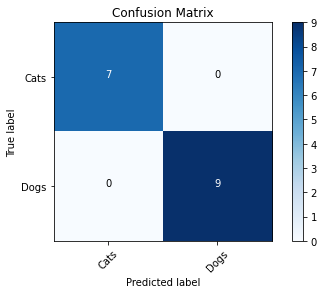

In [ ]:
cm_plot_labels = ['Cats','Dogs']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
score = model.evaluate(train_ds, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
image_batch, label_batch = next(iter(test_ds.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_ids = np.argmax(predicted_batch, axis=-1)

In [ ]:
for i in range(0,len(predicted_ids)):
  print(str(predicted_ids[i]) + " - " + str(label_batch[i]))

In [ ]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')